In [15]:
import csv

import numpy as np
import pandas as pd

from binning import BalancedBinningReference

from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split as tts

from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

In [2]:
left = pd.read_csv('goodstuff.csv.xz')

/home/lwgray/anaconda3/envs/ddl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
left = left.groupby(['asin']).last()

In [20]:
right = pd.read_csv('test2.csv', header=None, index_col=0,
                    names=['asin','brand','length', 'width','height','salesrank',
                           'manufacturer', 'max_age', 'min_age', 'product_group'])

In [21]:
right = pd.read_csv('test2.csv', header=None,
                    names=['asin','brand','length', 'width','height','salesrank',
                           'manufacturer', 'max_age', 'min_age', 'product_group'])

In [22]:
right.columns

Index(['asin', 'brand', 'length', 'width', 'height', 'salesrank',
       'manufacturer', 'max_age', 'min_age', 'product_group'],
      dtype='object')

In [23]:
right = right[['asin','brand','length', 'width','height',
               'manufacturer', 'max_age', 'min_age', 'product_group']]
right = right.drop_duplicates(subset='asin', keep='last')

In [36]:
m = left.join(right.set_index('asin'), how='inner')
m.brand = m.brand.str.lower()
m.brand = m.brand.str.replace('-',' ')
m['bins_rank'] = np.digitize(m.salesrank, [4015, 29325, 94438, 262902])

In [25]:
X = m[['amazon_sales_price', 'purchaseprice', 'length', 'width', 'height']].as_matrix()

y = m[['salesrank']].as_matrix()

The binning reference values are: [4015, 29325, 94438, 262902]


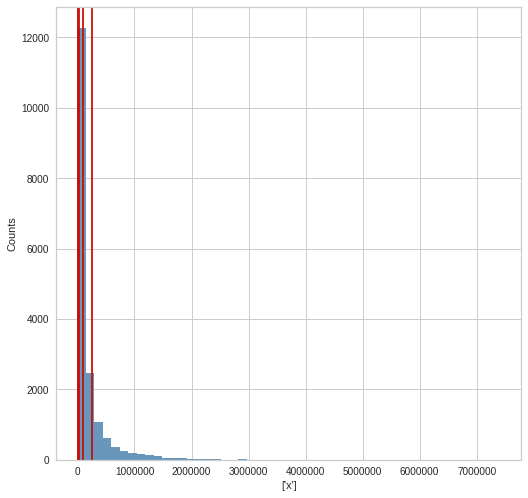

In [35]:
viz = BalancedBinningReference(bins=5)
viz.fit(m.salesrank)
viz.poof()

In [38]:
train_X, test_X, train_y, test_y = tts(X,y,test_size=0.20)

In [39]:
clf = Lasso()
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
mae = mean_absolute_error(y_pred=y_pred, y_true=test_y)
mae

1.1897152785778766

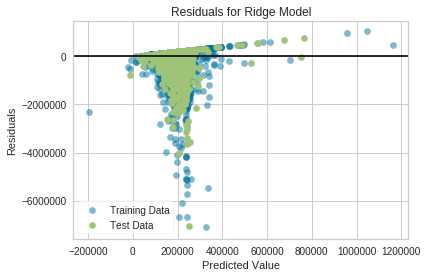

In [32]:
ridge = Ridge()
viz = ResidualsPlot(ridge)
viz.fit(train_X, train_y)
viz.score(test_X, test_y)
g = viz.poof()

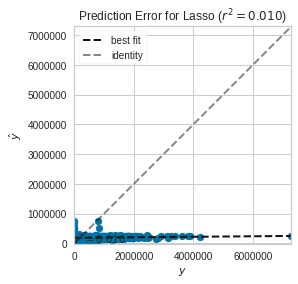

In [33]:
lasso = Lasso()
viz = PredictionError(lasso)
viz.fit(train_X, train_y)
viz.score(test_X, test_y)
g = viz.poof()


/home/lwgray/anaconda3/envs/ddl/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lwgray/anaconda3/envs/ddl/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


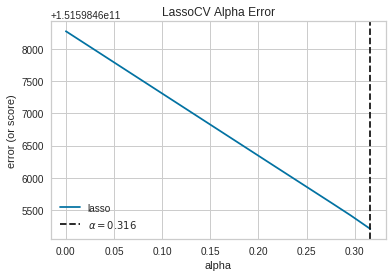

In [34]:
# Create a list of alphas to cross-validate against
alphas = np.logspace(-12, -0.5, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)

visualizer.fit(train_X, train_y)  # Fit the training data to the visualizer
g = visualizer.poof()  